In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download -d pcbreviglieri/pneumonia-xray-images

100% 1.14G/1.14G [00:12<00:00, 107MB/s] 
100% 1.14G/1.14G [00:12<00:00, 98.3MB/s]


In [4]:
import zipfile
zf = "/content/pneumonia-xray-images.zip"
target_dir = "/content/dataset/cnn/pneumonia_revamped"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [6]:
train_path = '/content/dataset/cnn/pneumonia_revamped/train'
test_path = '/content/dataset/cnn/pneumonia_revamped/test'
valid_path = '/content/dataset/cnn/pneumonia_revamped/val'

In [7]:
batch_size = 32

img_height = 150
img_width = 150

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_gen = ImageDataGenerator(rescale=1./255,zoom_range=0.5,shear_range=0.3,horizontal_flip=True)
test_data_gen = ImageDataGenerator(rescale=1./255)

In [9]:
train = image_gen.flow_from_directory(train_path,target_size=(img_height,img_width),class_mode='binary',batch_size=batch_size)
test = test_data_gen.flow_from_directory(test_path,target_size=(img_height,img_width),shuffle=False,class_mode='binary',batch_size=batch_size)
valid = test_data_gen.flow_from_directory(valid_path,target_size=(img_height,img_width),class_mode='binary',batch_size=batch_size)

Found 4192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


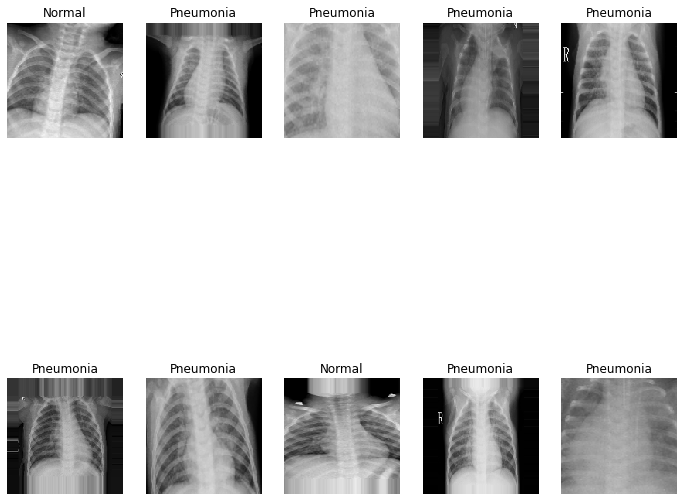

In [10]:
plt.figure(figsize=(12,12))
for i in range(0,10):
  plt.subplot(2,5,i+1)
  for X_batch,Y_batch in train:
    image = X_batch[0]
    dic = {0:'Normal',1:'Pneumonia'}
    plt.title(dic.get(Y_batch[0]))
    plt.axis('off')

    plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
    break

    plt.tight_layout()
    plt.show()

In [11]:
import keras
from keras.models import Sequential
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, BatchNormalization

from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

import keras.backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers import SeparableConv2D, MaxPool2D, LeakyReLU
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

# Setting seeds for reproducibility
seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)

In [13]:
inputs = Input(shape=(img_width, img_height, 3))

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

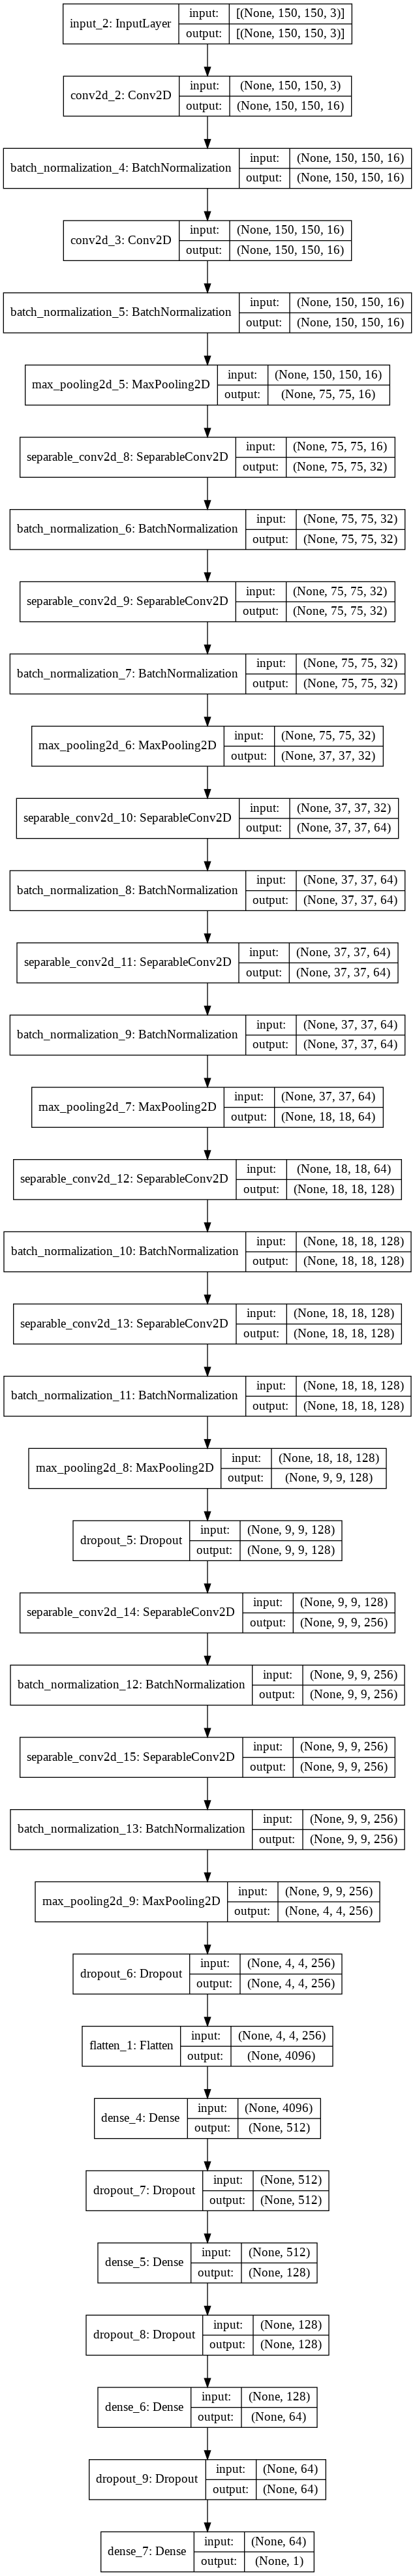

In [14]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True,show_layer_names=True,rankdir='TB',expand_nested=True)

In [15]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced',np.unique(train.classes),train.classes)
cw = dict(zip(np.unique(train.classes),weights))
print(cw)

{0: 1.9371534195933457, 1: 0.6739549839228296}


In [16]:
model.fit(train,epochs=25,validation_data=valid,class_weight=cw,batch_size=512,callbacks=[checkpoint,lr_reduce])

Epoch 1/25
131/131 [==============================] - 321s 2s/step - loss: 1.7300 - accuracy: 0.6307 - val_loss: 0.6889 - val_accuracy: 0.7433
Epoch 2/25
131/131 [==============================] - 317s 2s/step - loss: 0.5144 - accuracy: 0.8002 - val_loss: 0.8399 - val_accuracy: 0.2567
Epoch 3/25
131/131 [==============================] - 318s 2s/step - loss: 0.4092 - accuracy: 0.8293 - val_loss: 0.6457 - val_accuracy: 0.7808
Epoch 4/25
131/131 [==============================] - 320s 2s/step - loss: 0.3534 - accuracy: 0.8552 - val_loss: 0.4696 - val_accuracy: 0.8385

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 5/25
131/131 [==============================] - 320s 2s/step - loss: 0.3166 - accuracy: 0.8700 - val_loss: 0.3824 - val_accuracy: 0.8327
Epoch 6/25
131/131 [==============================] - 319s 2s/step - loss: 0.2608 - accuracy: 0.8965 - val_loss: 0.4103 - val_accuracy: 0.8173

Epoch 00006: ReduceLROnPlateau reducing learning rate to 9.0

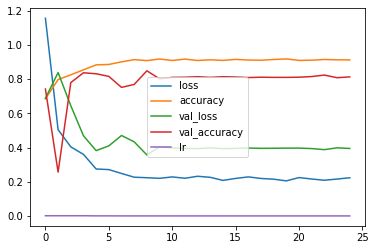

In [17]:
pd.DataFrame(model.history.history).plot()

In [18]:
test_accu = model.evaluate(test)
print('The testing accuracy is - ',test_accu[1]*100,'%')

20/20 [==============================] - 15s 691ms/step - loss: 0.3456 - accuracy: 0.8590
The testing accuracy is -  85.89743375778198 %
